In [0]:
'''For computing and then plotting Average Causal Effect of the 4 features on the 3 classes'''

In [0]:
%matplotlib inline
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import os,csv,math, sys,joblib,copy,pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection, sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

In [0]:
class neural_network(nn.Module):
    def __init__(self, num_input, num_hidden,num_output):
        super(neural_network, self).__init__()
        self.hidden = nn.Linear(num_input,num_hidden)
        self.out = nn.Linear(num_hidden,num_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        return self.out(x)

model = torch.load("/gdrive/My Drive/IRIS/Code/iris_double_model_8")#Loading the save module

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [0]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# Loading the dataset
dataset = pd.read_csv('/gdrive/My Drive/IRIS/Code/Iris_Dataset.csv')
dataset = pd.get_dummies(dataset, columns=['Species']) # One Hot Encoding
values = list(dataset.columns.values)

y = dataset[values[-3:]]
y = np.array(y, dtype='float32')
X = dataset[values[:-3]]
X = np.array(X, dtype='float32')

# Shuffle Data
indices = np.random.choice(len(X), len(X), replace=False)
X_values = X[indices]

scaler = MinMaxScaler()
test_size = 30
X_train = X_values[:-test_size]
X_train = scaler.fit_transform(X_train)

X_values = scaler.transform(X_values)

y_values = y[indices]


In [0]:
#Calculating covariance and mean of data
cov = np.cov(X_values, rowvar=False)
means = np.mean(X_values, axis=0)

cov=np.array(cov)
mean_vector = np.array(means)

n_classes=3
num_c=4#no. of features
num_alpha=1000

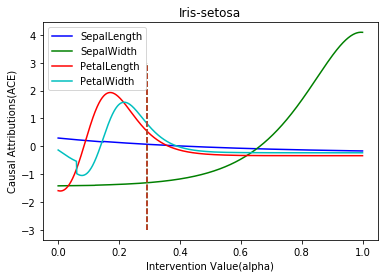

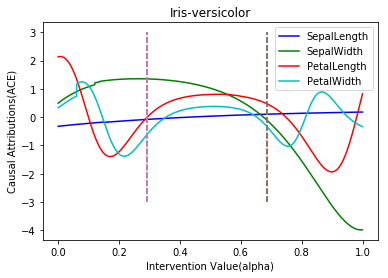

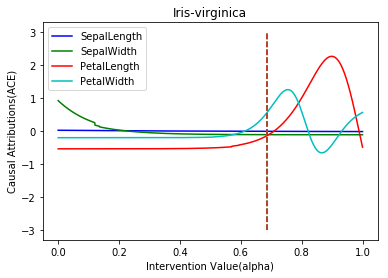

In [0]:
feature_name = {0:"SepalLength",1:"SepalWidth",2:"PetalLength",3:"PetalWidth",4:"Species"}
col={0:"b",1:"g",2:"r",3:"c"}
tit={0:"Iris-setosa",1:"Iris-versicolor",2:"Iris-virginica"}
for output_index in range(0,n_classes):#For every class
    plt.figure()
    for t in range(0,num_c):#For every feature
        expectation_do_x = []
        inp=copy.deepcopy(mean_vector)
        
        for x in np.linspace(0, 1, num_alpha):
           
            inp[t] = x
            input_torchvar = autograd.Variable(torch.FloatTensor(inp), requires_grad=True)
            
            output=F.softmax(model(input_torchvar), dim=-1) 
            
            o1=output.data.cpu()
            val=o1.numpy()[output_index]#first term in interventional expectation                                       
            
            grad_mask_gradient = torch.zeros(n_classes)
            grad_mask_gradient[output_index] = 1.0
            #calculating the hessian
            first_grads = torch.autograd.grad(output.cpu(), input_torchvar.cpu(), grad_outputs=grad_mask_gradient, retain_graph=True, create_graph=True)

            for dimension in range(0,num_c):#Tr(Hessian*Covariance)
                if dimension == t:
                  continue
                temp_cov = copy.deepcopy(cov)
                temp_cov[dimension][t] = 0.0#row,col in covariance corresponding to the intervened one made 0
                grad_mask_hessian = torch.zeros(num_c)
                grad_mask_hessian[dimension] = 1.0

                #calculating the hessian
                hessian = torch.autograd.grad(first_grads, input_torchvar, grad_outputs=grad_mask_hessian, retain_graph=True, create_graph=False)

                val += np.sum(0.5*hessian[0].data.numpy()*temp_cov[dimension])#adding second term in interventional expectation
            expectation_do_x.append(val)#append interventional expectation for given interventional value
        plt.title(tit[output_index])       
        plt.xlabel('Intervention Value(alpha)')
        plt.ylabel('Causal Attributions(ACE)')
        
        #Baseline is np.mean(expectation_do_x)
        plt.plot(np.linspace(0, 1, num_alpha), np.array(expectation_do_x) - np.mean(np.array(expectation_do_x)), label = feature_name[t],color=col[t])
        plt.legend()
        #Plotting vertical lines to indicate regions
        if output_index == 0:
            plt.plot(np.array([0.2916666567325592]*1000),np.linspace(-3,3,1000),"--")

        if output_index == 1:	
            plt.plot(np.array([0.2916666567325592]*1000),np.linspace(-3,3,1000),"--")
            plt.plot(np.array([0.6874999403953552]*1000),np.linspace(-3,3,1000),"--")
        if output_index == 2:	
            plt.plot(np.array([0.6874999403953552]*1000),np.linspace(-3,3,1000),"--")
        plt.savefig("/gdrive/My Drive/IRIS/Code/"+str(output_index)+".png")


In [0]:
model = torch.load("/gdrive/My Drive/IRIS/Code/iris_double_model_8")
model

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


neural_network(
  (hidden): Linear(in_features=4, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
)

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/
